In [45]:
import numpy as np
from scipy import interpolate
import time
import math
import matplotlib.pyplot as plt
# from misc.golden_section_search import Search

In [46]:
"""
Michael Pham
November 2024

much thanks, heavy inspiration from Prof. Heer from Ch. 10.1.2 in Heer/Maussner, Dynamic General Equilibrium Modeling: Computational
Methods and Applications, Algorithm 10.1.1

third iteration, version 2 with K, Z, and L as state variable
no consumption tax, no human capital investment structure
"""

'\nMichael Pham\nNovember 2024\n\nmuch thanks, heavy inspiration from Prof. Heer from Ch. 10.1.2 in Heer/Maussner, Dynamic General Equilibrium Modeling: Computational\nMethods and Applications, Algorithm 10.1.1\n\nthird iteration, version 2 with K, Z, and L as state variable\nno consumption tax, no human capital investment structure\n'

In [47]:
exp = np.e
log = math.log

In [48]:
# Parameters - households and firms
beta = 0.935  # discount factor
eta = 2.0    # coefficient of relative risk aversion
gamma = 0.5  # disutility from working
alpha = 0.33 # capital share in production
delta = 0.1  # depreciation rate
# omega = 0.1  # parent education time factor
# phi_p = 0.5  # share of parental input in education
# psi_e = 0.5  # CES parameter for education inputs
# theta_I = 0.7  # human capital investment effectiveness
tfp = 1      #total factor productivity
small = 0.00001
neg = -1e10

#Parameters - government
tau = 0.15
Ie_gdp = 0.03 # public education investment as percent of GDP
Iz_gdp = 0.06 # public infrastructure investment as percent of GDP percent of GDP
sigma_bar = 0.3  # public investment inefficiency
G_gdp = 0.07      # grants (as a fraction of GDP)
psi = 0.1   # public infrastructure elasticity
# nu = 0.6     # debt-to-GDP ratio limit

# Initial guesses
# K_init = 1
# H_init = 1
# L_init = 0.2
# Z_init = 1
# tau_init = 0.15  # Initial guess for tax rate
# T_init = 0.1  # Initial guess for transfers
# D_init = 0

# Grid spec
na = 50  # number of points in capital grid
nl = 50  # number of points in capital grid

# nH = 20   # number of points in human capital grid
# nZ = 20   # number of points in public infrastructure grid
# Kmin = 0
# Kmax = 10
# Hmin = 0
# Hmax = 10
# Zmin = 0
# Zmax = 10

k_start = 0
k_min, k_max = 0, 2
k_grid =  np.linspace(k_min, k_max, na)   # asset grid 
k_eps = (k_grid[1]-k_grid[0])/na    #  test for corner solution
phi = 0.8           # updating of the aggregate capital stock K in outer loop
tolerance = 0.001        # percentage deviation of final solution 
tolerance_gs = 1e-10       # tolerance for golden section search 
max_iters = 30             # maximum number of iteration over K

l_start = 0
l_min, l_max = 0, 1
l_grid =  np.linspace(l_min, l_max, nl)   # asset grid 



# Number of periods
periods = 40
child_periods = 18

Production Equations

In [49]:
def production(Z_prev, K_prev, H, L):
    """
    production function (eq 1 mod)

    params: K_t-1, H_t, L_t
    returns: Y
    """
    return tfp * Z_prev**psi * K_prev**(alpha-psi) * (H*L)**(1-alpha-psi)

def wage_rate(Z_prev, K_prev, H, L):
    """
    marginal product of labor (eq 2 mod)

    params: K_t-1, H_t, L_t
    returns: w_t
    """
    return tfp * Z_prev**psi * (1-alpha-psi) * (K_prev)**(alpha-psi) * (H*L)**(-alpha-psi)

def interest_rate(Z_prev, K_prev, H, L):
    """
    marginal product of capital minus depreciation (eq 3 mod + interest steady state)

    params: K_t-1, H_t, L_t
    returns: r_t 
    """
    return tfp * (alpha -psi) * Z_prev**psi * (H*L)**(1-alpha-psi) * K_prev**(alpha-1-psi) - delta

Government Equations

In [50]:
def transfer(K_prev, H, L, G, tau, w, r):
  """
  government budget (eq 6 mod)
  assumes balanced budget, no borrowing

  params: K_t-1, H_t, L_t, G, tau, w_t, r_t
  returns: T (transfers)
  """
  tax_revenue = tau*w*H*L + tau*r*K_prev
  total_revenue = tax_revenue + G
  return total_revenue #- Y*Ie_gdp

Household Equations

In [51]:
def utility(c, l):
  """
  household utility function (eq 8)
  adds modified case of when full labor, so utility is not 0

  params: c_t, l_t
  returns: utility
  """

  if l == 1:
    return np.log(c+ small) + gamma * np.log(l)

  return (((c+small) * (1-l) ** gamma) ** (1-eta) - 1) / (1-eta)


def value_function(next_value_interpolator, k, k_prev, l, h, w, r, tau, T):
  """
  household bellman equation (eq 14)
  
  params: k_t, k_t-1, c_t, l_t, h_t, w_t, r_t, tau, T
  returns: value of this period's bellman equation
  """
  if l < 0: # corner solution 0<=n<=1
    l = 0
  elif l > 1: # corner solution
    l = 1

  c = (1-tau)*w*h*l - k + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
  if c <= 0:
    return neg
  # print(f"in value function, c: {c}, l, {l}, interpolator, {next_value_interpolator}")
  return utility(c, l) + beta * next_value_interpolator(k, l) # Added l as second argument

def consumption(k_prev, k, h, l, w, r, tau, T):
  return (1-tau)*w*h*l + (1+ r)*k_prev - tau*r*max(k_prev, 0) + T - k


In [52]:
#initialize steady state variable predictions
h_init = 1
l_init = 0.2
r_init = beta**(-1) - 1

Z_bar = 0.1
L_bar = l_init #refers to guess of L in this period
H_bar = h_init #refers to guess of H in this period
# K_bar = ((r_init + delta)/(alpha*tfp))**(1/(alpha-1)) * (H_bar * L_bar) #new guess!
K_bar = 0.25
L_old = L_bar + 2
H_old = H_bar + 100
K_old = K_bar + 100
Z_old = Z_bar + 100

h = 1
l = 0.2

K_bar

0.25

In [53]:
class Search:
  
  def __init__(self, next_value_interpolator, function, left, initial_guess, right, tolerance, k_prev, l, h, w, r, tau, T) -> None:
    self.next_value_interpolator = next_value_interpolator
    self.function = function
    self.left = left
    self.right = right
    self.initial_guess = initial_guess
    self.tolerance = tolerance
    self.k_prev = k_prev
    self.l = l
    self.h = h
    self.w = w
    self.r = r
    self.tau = tau
    self.T = T

  def evaluate_function(self, k):
    return self.function(self.next_value_interpolator, k, self.k_prev, self.l, self.h, self.w, self.r, self.tau, self.T)

  def find_max(self):
    golden_ratio = ((1+np.sqrt(5))/2)
    golden_ratio_dec = golden_ratio - 1

    if abs(self.right - self.initial_guess) >= abs(self.initial_guess - self.left):
      golden_left = self.initial_guess
      golden_right = self.initial_guess + (1 - golden_ratio_dec) * (self.right - self.initial_guess)
    else:
      golden_right = self.initial_guess
      golden_left = self.initial_guess - (1 - golden_ratio_dec) * (self.initial_guess - self.left)

    while (self.right - self.left) > self.tolerance:
      if self.evaluate_function(golden_left) < self.evaluate_function(golden_right):
        self.left = golden_left
      elif self.evaluate_function(golden_left) > self.evaluate_function(golden_right):
        self.right = golden_right
      elif self.evaluate_function(golden_left) == self.evaluate_function(golden_right):
        self.left = golden_left
        self.right = golden_right

      golden_left = self.left + (1 - golden_ratio_dec) * (self.right-self.left)
      golden_right = self.left + (golden_ratio_dec) * (self.right-self.left)
    
    return self.left if self.evaluate_function(self.left) > self.evaluate_function(self.right) else self.right

iter: 0; K change: 400.00; H change: 100.00; L change: 10.00; Z change: 1000.00
tax_revenue: 0.023938188666801773
grants: 0.016151443388967707
T: 0.026245537722368588
iter: 0; K: 0.25; H: 1.00; L: 0.20; Z: 0.10
iter: 0; Y: 0.23; tau: 0.15; T: 0.03
iter: 0, i: 39, k: 0.25, l: 0.2
checkpoint 2
iter: 0, i: 38, k: 0.25, l: 0.2
checkpoint 2
iter: 0, i: 37, k: 0.25, l: 0.2
checkpoint 2
iter: 0, i: 36, k: 0.25, l: 0.2
checkpoint 2
iter: 0, i: 35, k: 0.25, l: 0.2
checkpoint 2
iter: 0, i: 34, k: 0.25, l: 0.2
checkpoint 2
iter: 0, i: 33, k: 0.25, l: 0.2
checkpoint 2
iter: 0, i: 32, k: 0.25, l: 0.2
checkpoint 2
iter: 0, i: 31, k: 0.25, l: 0.2
checkpoint 2
iter: 0, i: 30, k: 0.25, l: 0.2
checkpoint 2
iter: 0, i: 29, k: 0.25, l: 0.2
checkpoint 2
iter: 0, i: 28, k: 0.25, l: 0.2
checkpoint 2
iter: 0, i: 27, k: 0.25, l: 0.2
checkpoint 2
iter: 0, i: 26, k: 0.25, l: 0.2
checkpoint 2
iter: 0, i: 25, k: 0.25, l: 0.2
checkpoint 2
iter: 0, i: 24, k: 0.25, l: 0.2
checkpoint 2
iter: 0, i: 23, k: 0.25, l: 0.2


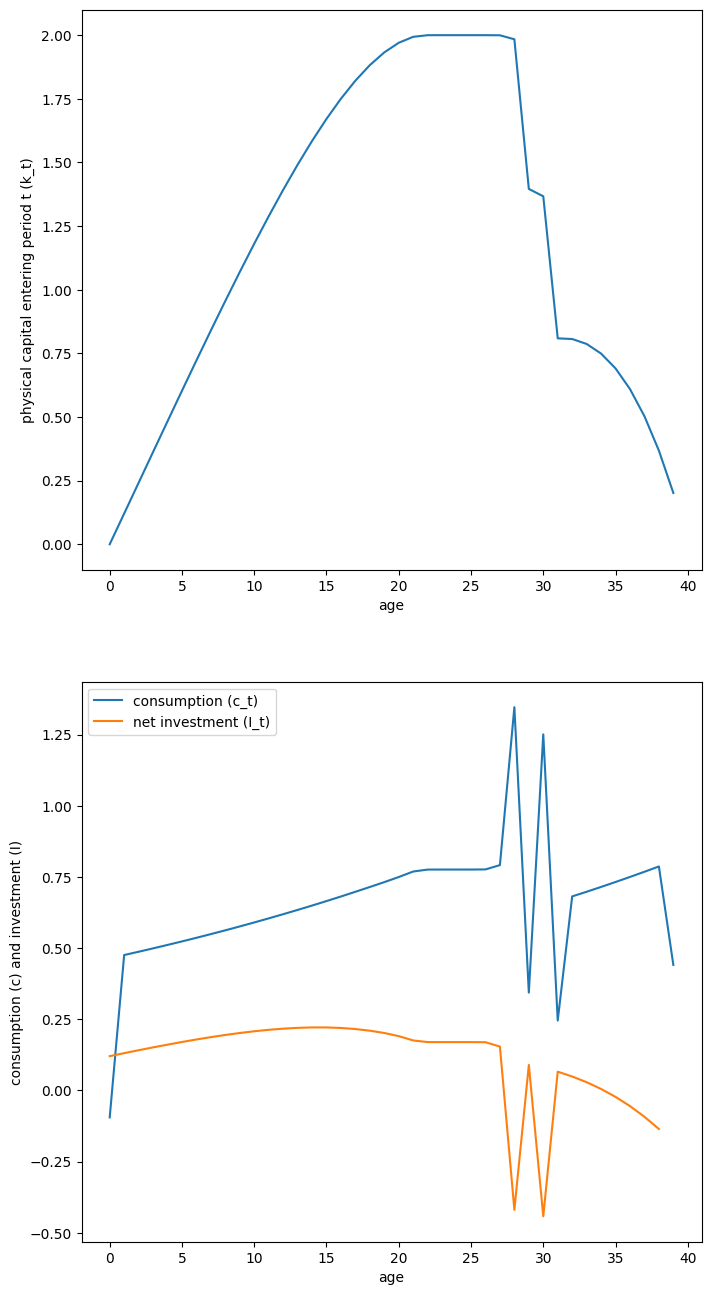

iter: 1; K change: 0.43; H change: 0.00; L change: 0.42; Z change: 0.00
tax_revenue: 0.03656126649893043
grants: 0.025161105194463615
T: 0.04015571009813952
iter: 1; K: 0.44; H: 1.00; L: 0.35; Z: 0.10
iter: 1; Y: 0.36; tau: 0.15; T: 0.04
iter: 1, i: 39, k: 0.4381371127719075, l: 0.34729172320213875
checkpoint 2
iter: 1, i: 38, k: 0.4381371127719075, l: 0.34729172320213875
checkpoint 2
iter: 1, i: 37, k: 0.4381371127719075, l: 0.34729172320213875
checkpoint 2
iter: 1, i: 36, k: 0.4381371127719075, l: 0.34729172320213875
checkpoint 2
iter: 1, i: 35, k: 0.4381371127719075, l: 0.34729172320213875
checkpoint 2
iter: 1, i: 34, k: 0.4381371127719075, l: 0.34729172320213875
checkpoint 2
iter: 1, i: 33, k: 0.4381371127719075, l: 0.34729172320213875
checkpoint 2
iter: 1, i: 32, k: 0.4381371127719075, l: 0.34729172320213875
checkpoint 2
iter: 1, i: 31, k: 0.4381371127719075, l: 0.34729172320213875
checkpoint 2
iter: 1, i: 30, k: 0.4381371127719075, l: 0.34729172320213875
checkpoint 2
iter: 1, i: 

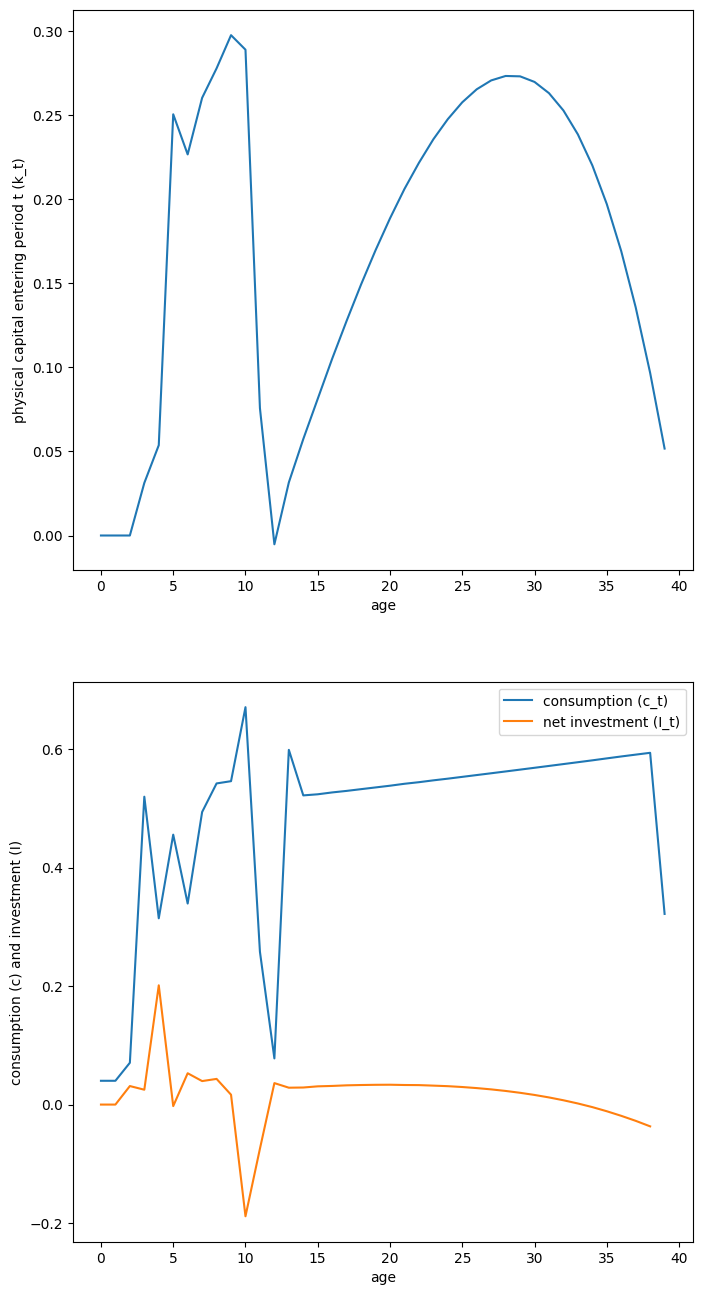

iter: 2; K change: 0.14; H change: 0.00; L change: 0.23; Z change: 0.05
tax_revenue: 0.04305697693746472
grants: 0.02848156035050013
T: 0.047125771273250454
iter: 2; K: 0.38; H: 1.00; L: 0.45; Z: 0.10
iter: 2; Y: 0.41; tau: 0.15; T: 0.05
iter: 2, i: 39, k: 0.38457033946427055, l: 0.45099436762018624
checkpoint 2
iter: 2, i: 38, k: 0.38457033946427055, l: 0.45099436762018624
checkpoint 2
iter: 2, i: 37, k: 0.38457033946427055, l: 0.45099436762018624
checkpoint 2
iter: 2, i: 36, k: 0.38457033946427055, l: 0.45099436762018624
checkpoint 2
iter: 2, i: 35, k: 0.38457033946427055, l: 0.45099436762018624
checkpoint 2
iter: 2, i: 34, k: 0.38457033946427055, l: 0.45099436762018624
checkpoint 2
iter: 2, i: 33, k: 0.38457033946427055, l: 0.45099436762018624
checkpoint 2
iter: 2, i: 32, k: 0.38457033946427055, l: 0.45099436762018624
checkpoint 2
iter: 2, i: 31, k: 0.38457033946427055, l: 0.45099436762018624
checkpoint 2
iter: 2, i: 30, k: 0.38457033946427055, l: 0.45099436762018624
checkpoint 2
it

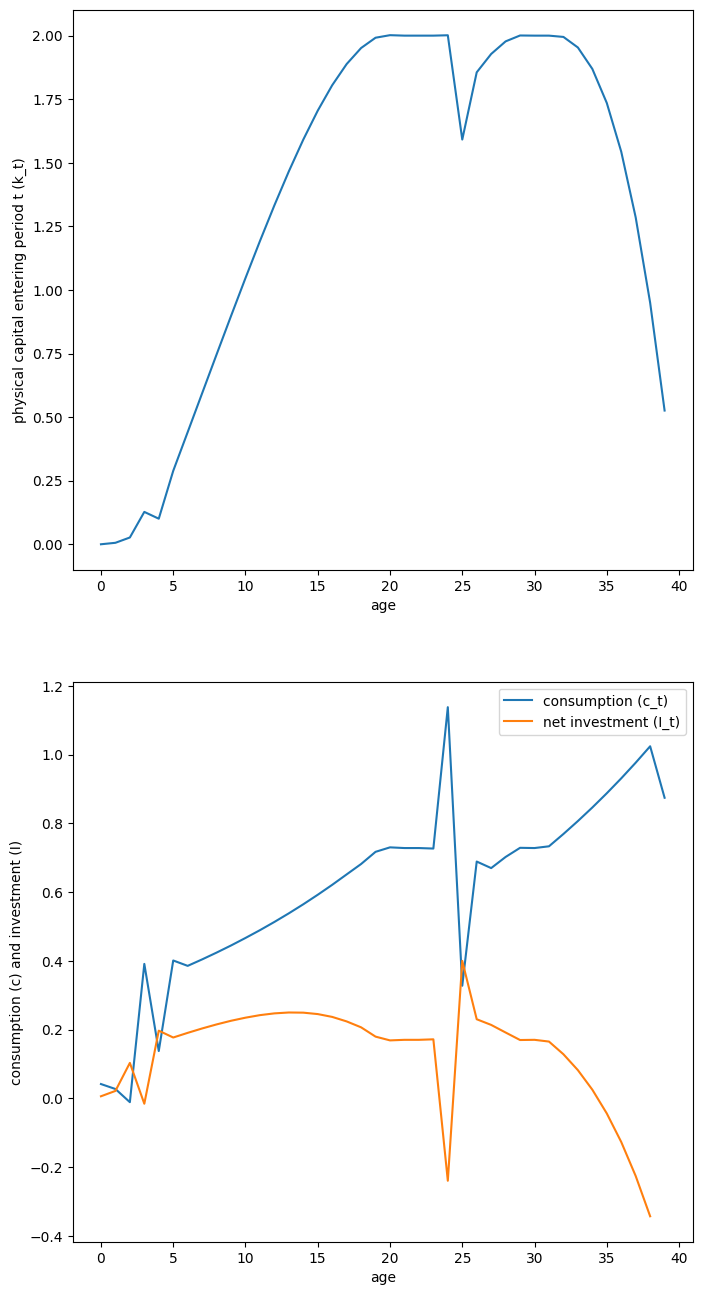

iter: 3; K change: 0.34; H change: 0.00; L change: 0.17; Z change: 0.06
tax_revenue: 0.05129977423075179
grants: 0.034997351815670215
T: 0.056299395918704684
iter: 3; K: 0.58; H: 1.00; L: 0.54; Z: 0.11
iter: 3; Y: 0.50; tau: 0.15; T: 0.06
iter: 3, i: 39, k: 0.5797124016455231, l: 0.5427014829607664
checkpoint 2
iter: 3, i: 38, k: 0.5797124016455231, l: 0.5427014829607664
checkpoint 2
iter: 3, i: 37, k: 0.5797124016455231, l: 0.5427014829607664
checkpoint 2
iter: 3, i: 36, k: 0.5797124016455231, l: 0.5427014829607664
checkpoint 2
iter: 3, i: 35, k: 0.5797124016455231, l: 0.5427014829607664
checkpoint 2
iter: 3, i: 34, k: 0.5797124016455231, l: 0.5427014829607664


In [54]:
iteration = -1
K_diff = 1 + tolerance
state_var_iter_array = np.zeros((max_iters,4))

#loop while max_iters not exceeded and difference between this K guess and previous K guess is greater than acceptable tolerance
while iteration < max_iters - 1 and K_diff > tolerance:
  iteration += 1
  K_diff = abs((K_bar - K_old) / K_bar)
  H_diff = abs((H_bar - H_old) / H_bar)
  L_diff = abs((L_bar - L_old) / L_bar)
  Z_diff = abs((Z_bar - Z_old) / Z_bar)
  print(f"iter: {iteration}; K change: {K_diff:.2f}; H change: {H_diff:.2f}; L change: {L_diff:.2f}; Z change: {Z_diff:.2f}")

  #calculate variables based on new guess of K, H, L
  w = wage_rate(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  r = interest_rate(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  Y = production(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  grants = G_gdp * Y

  Iz = Iz_gdp * Y
  Ie = Ie_gdp * Y

  tax_revenue = tau*w*H_bar*L_bar + tau*r*K_bar
  print(f"tax_revenue: {tax_revenue}")
  print(f"grants: {grants}")
  T = tax_revenue + grants
  T = transfer(K_prev = K_bar, H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r) - Iz
  print(f"T: {T}")

  print(f"iter: {iteration}; K: {K_bar:.2f}; H: {H_bar:.2f}; L: {L_bar:.2f}; Z: {Z_bar:.2f}")
  print(f"iter: {iteration}; Y: {Y:.2f}; tau: {tau:.2f}; T: {T:.2f}")

  #set the old state variables to be previous iteration state variables
  K_old = K_bar
  H_old = H_bar
  L_old = L_bar
  Z_old = Z_bar
  state_var_iter_array[iteration, 0] = K_old
  state_var_iter_array[iteration, 1] = H_old
  state_var_iter_array[iteration, 2] = L_old
  state_var_iter_array[iteration, 3] = Z_old

  value_array = np.zeros((na, nl, periods + 1)) #value function array for each k,l combination
  k_optimal_array = np.zeros((na, nl, periods)) #optimal capital array
  c_optimal_array = np.zeros((na, nl, periods)) #optimal consumption array
  l_optimal_array = np.zeros((na, nl, periods)) #optimal labor array
  h_optimal_array = np.zeros((na, nl, periods)) #optimal human capital array
  hc_optimal_array = np.zeros((na, nl, child_periods)) #optimal child human capital array

  #compute last period value function
  for i in range(na):
    for j in range(nl):
      final_period_assets = (1-tau)*w*H_bar*l_grid[j] + (1+r)*k_grid[i] - tau*r*max(k_grid[i], 0) + T
      value_array[i,j, periods - 1] = utility(final_period_assets, l_grid[j])
      c_optimal_array[i,j, periods - 1] = final_period_assets
      l_optimal_array[i,j, periods - 1] = l_grid[j]
      h_optimal_array[i,j, periods - 1] = h

  #compute policy function
  for i in range(periods-1, 0, -1): #loop backwards from age 60 to 0
    print(f"iter: {iteration}, i: {i}, k: {K_bar}, l: {L_bar}")
    
    # Create 2D interpolator over k and l grids
    vr_polate = interpolate.RectBivariateSpline(k_grid, l_grid, value_array[:,:,i])

    # for j in range(na): #iterate over possible initial capital
    #   for n in range(nl): #iterate over possible initial labor
    #     k0 = k_grid[j]
    #     l0 = l_grid[n]

    #     # Find optimal k and l using grid search over both dimensions
    #     max_value = float('-inf')
    #     k_opt = 0
    #     l_opt = 0
        
    #     for k_idx in range(na):
    #       for l_idx in range(nl):
    #         k = k_grid[k_idx]
    #         l = l_grid[l_idx]
    #         val = value_function(vr_polate, k, k0, l, h, w, r, tau, T)
            
    #         if val > max_value:
    #           max_value = val
    #           k_opt = k
    #           l_opt = l

    #     k_optimal_array[j,n,i-1] = k_opt
    #     l_optimal_array[j,n,i-1] = l_opt
    #     value_array[j,n,i-1] = max_value
    #     print('checkpoint 1', k_idx, l_idx)
    #     c_optimal_array[j,n,i-1] = (1-tau)*w*h*l_opt + r*k0 - tau*r*max(k0, 0) + T - k_opt

    for j in range(na):
        for n in range(nl):
            k0 = k_grid[j]
            l0 = l_grid[n]
            
            # Instead of grid search, use optimization methods
            from scipy.optimize import minimize
            
            def objective(x):
                k, l = x
                # Return negative value since minimize finds minimum
                return -value_function(vr_polate, k, k0, l, h, w, r, tau, T)
            
            # Initial guess and bounds
            x0 = [k0, l0]  
            bounds = [(k_min, k_max), (l_min, l_max)]
            
            # Run optimization
            result = minimize(objective, x0, bounds=bounds, method='L-BFGS-B')
            k_opt, l_opt = result.x
            
            k_optimal_array[j,n,i-1] = k_opt
            l_optimal_array[j,n,i-1] = l_opt
            value_array[j,n,i-1] = -result.fun  # Note: negative since we minimized negative value
            c_optimal_array[j,n,i-1] = (1-tau)*w*h*l_opt + r*k0 - tau*r*max(k0, 0) + T - k_opt


    print('checkpoint 2')
  k_gen = np.zeros(periods)
  l_gen = np.zeros(periods)
  c_gen = np.zeros(periods)
  h_gen = np.zeros(periods)
  i_gen = np.zeros(periods)

  k_gen[0] = k_start
  l_gen[0] = l_start

  for q in range(periods - 1):
    # Create 2D interpolators for k and l policy functions
    k_polate = interpolate.RectBivariateSpline(k_grid, l_grid, k_optimal_array[:,:,q])
    l_polate = interpolate.RectBivariateSpline(k_grid, l_grid, l_optimal_array[:,:,q])

    k_gen[q+1] = k_polate(k_gen[q], l_gen[q])[0,0]
    l_gen[q+1] = l_polate(k_gen[q], l_gen[q])[0,0]
    
    c_gen[q] = consumption(k_prev=k_gen[q], k=k_gen[q+1], h=h, l=l_gen[q], w=w, r=r, tau=tau, T=T)
    i_gen[q] = -c_gen[q] + (1-tau)*w*h*l_gen[q] + (r+delta)*k_gen[q] - tau*(r+delta)*max(k_gen[q], 0) + T

  K_new = np.mean(k_gen)
  L_new = np.mean(l_gen)

  K_bar = phi*K_old + (1-phi)*K_new
  L_bar = phi*L_old + (1-phi)*L_new

  Z_bar = (1-delta)*Z_old + (1-sigma_bar)*Iz

  final_period_assets = (1-tau)*w*H_bar*L_bar + (1+r)*k_gen[periods-1] - tau*r*max(k_gen[periods-1], 0) + T
  c_gen[periods-1] = final_period_assets

  print("Solution for aggregate capital stock K: " + str(K_bar))
  print("Solution for aggregate labor N: " + str(L_bar))

  fig, axes = plt.subplots(2, 1, figsize=(8, 16))
  axes[0].set_xlabel('age')
  axes[0].set_ylabel('physical capital entering period t (k_t)')
  axes[0].plot(k_gen)
  axes[1].set_xlabel('age')
  axes[1].set_ylabel('consumption (c) and investment (I)')
  axes[1].plot(c_gen, label='consumption (c_t)')
  axes[1].plot(i_gen[:-1], label='net investment (I_t)')
  axes[1].legend()
  plt.show()


aggregates

In [ ]:
print("Aggregate Factors of Production:")
print(f"Y: {Y:.4f}")
print(f"Z: {Z_old:.4f}")
print(f"K: {K_old:.4f}")
print(f"H: {H_old:.4f}")
print(f"L: {L_old:.4f}")
print("\nRates:")
print(f"Interest rate (r): {r:.4f}")
print(f"Return on capital (r^k): {r + delta:.4f}")


Aggregate Factors of Production:
Y: 0.2287
Z: 0.1012
K: 0.2392
H: 1.0000
L: 0.2000

Rates:
Interest rate (r): 0.1199
Return on capital (r^k): 0.2199
